In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_BenDoS_Mapped_Dataset.csv"

df = dk.read_csv(file_path)

2025-04-13 06:08:23.214710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744524503.343342    2919 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744524503.381369    2919 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744524503.685321    2919 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744524503.685400    2919 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744524503.685401    2919 computation_placer.cc:177] computation placer alr

In [ ]:
import matplotlib.pyplot as plt

# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
labels = [0, 1]
# Vẽ biểu đồ cột
plt.figure(figsize=(6, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =90)
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 600x500 with 0 Axes>

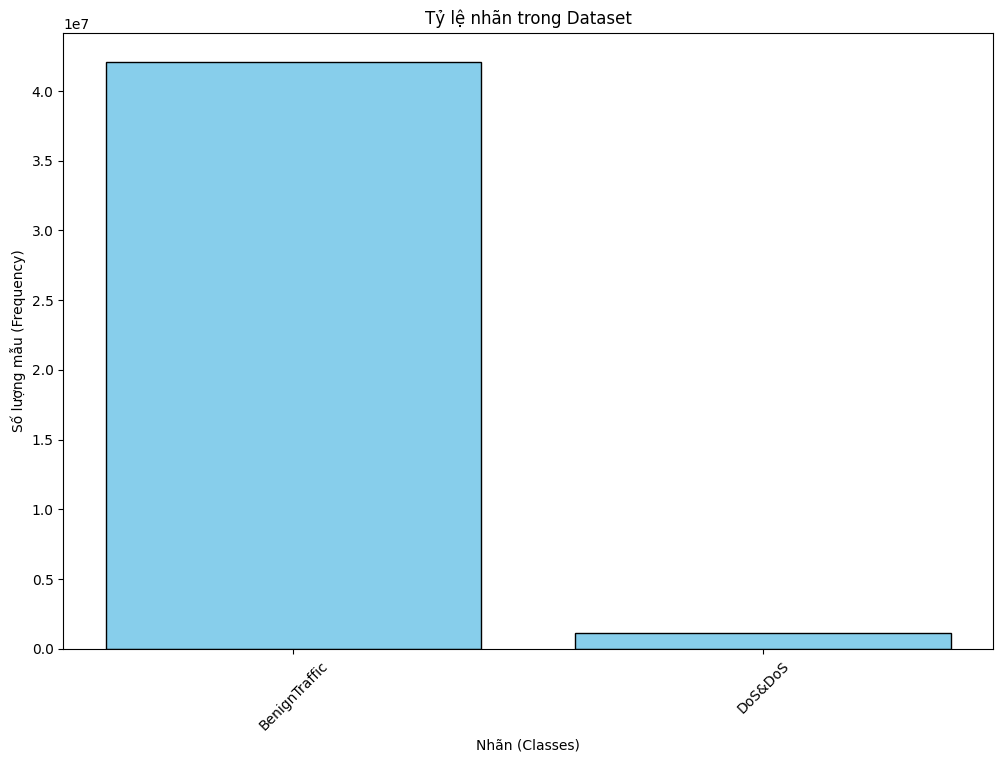

In [ ]:
# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
labels = [ 'DoS&DoS','BenignTraffic']
# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [4]:
#Global var 
batch_size = 512
ratio_test_all = 0.15

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size, num_classes): 
    def generator():
        for batch in dask_df.to_delayed():
            batch=batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values
            y_onehot = to_categorical(y, num_classes=num_classes)  

            num_splits = max(1, len(X) // batch_size)  # Đảm bảo không chia nhỏ quá mức
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y_onehot, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
                
    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

# from functools import partial
# def dask_generator(dask_df, batch_size=128, num_classes=10): 
#     for batch in dask_df.to_delayed():
#         batch = batch.compute()  
#         if batch.empty:
#             continue

#         X = batch.drop(columns='label').values.astype(np.float32)
#         y = batch['label'].values
#         y_onehot = to_categorical(y, num_classes=num_classes)  

#         num_splits = max(1, len(X) // batch_size)
#         X_batches = np.array_split(X, num_splits)
#         y_batches = np.array_split(y_onehot, num_splits)

#         for X_batch, y_batch in zip(X_batches, y_batches):
#             yield X_batch, y_batch 

# def dask_to_tf_dataset(dask_df, batch_size=128, num_classes=10): 
#     output_signature = ( 
#         tf.TensorSpec(shape=(None, dask_df.shape[1] - 1), dtype=tf.float32),  
#         tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),
#     )

#     return tf.data.Dataset.from_generator(
#         partial(dask_generator, dask_df, batch_size, num_classes), 
#         output_signature=output_signature
#     ).prefetch(tf.data.AUTOTUNE)

/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [5]:
train_gen = dask_to_tf_dataset(train_df, 512, 3).repeat()
test_gen = dask_to_tf_dataset(test_df, 512, 3)

I0000 00:00:1744466336.595941   95532 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5


In [6]:
from datetime import datetime, timedelta
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras
# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(filters=64, kernel_size=3,  padding="same",activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(output_shape, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# for batch in dataloader:
#     X_batch = batch[:, :-1]
#     y_batch = batch[:, -1]
#     y_onehot = to_categorical(y_batch, num_classes=10)
    
#     model.train_on_batch(X_batch, y_onehot, verbose=1)
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger("log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv" , append=True)
model.fit(train_gen, epochs=25, steps_per_epoch=70000, verbose = 1, callbacks=[csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time

# Lưu mô hình
model.save("saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras")

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)
Epoch 1/25


I0000 00:00:1744466343.675082   95603 service.cc:152] XLA service 0x7efd0800c500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744466343.675197   95603 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-12 13:59:03.722226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744466343.940698   95603 cuda_dnn.cc:529] Loaded cuDNN version 90300


   22/70000 ━━━━━━━━━━━━━━━━━━━━ 5:46 5ms/step - accuracy: 0.3583 - loss: 1.3812

2025-04-12 13:59:06.643085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

I0000 00:00:1744466346.670935   95603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  363/70000 ━━━━━━━━━━━━━━━━━━━━ 12:30 11ms/step - accuracy: 0.6714 - loss: 0.8113

2025-04-12 13:59:10.568318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



  776/70000 ━━━━━━━━━━━━━━━━━━━━ 16:48 15ms/step - accuracy: 0.7269 - loss: 0.6973

2025-04-12 13:59:17.788173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



70000/70000 ━━━━━━━━━━━━━━━━━━━━ 433s 6ms/step - accuracy: 0.8046 - loss: 0.5144
Epoch 2/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 427s 6ms/step - accuracy: 0.8062 - loss: 0.5068
Epoch 3/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 425s 6ms/step - accuracy: 0.8079 - loss: 0.4978
Epoch 4/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 430s 6ms/step - accuracy: 0.8100 - loss: 0.4894
Epoch 5/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 439s 6ms/step - accuracy: 0.8101 - loss: 0.4884
Epoch 6/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 442s 6ms/step - accuracy: 0.8084 - loss: 0.4960
Epoch 7/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 430s 6ms/step - accuracy: 0.8101 - loss: 0.4856
Epoch 8/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 427s 6ms/step - accuracy: 0.8115 - loss: 0.4764
Epoch 9/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 429s 6ms/step - accuracy: 0.8120 - loss: 0.4715
Epoch 10/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 434s 6ms/step - accuracy: 0.8121 - loss: 0.4675
Epoch 11/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 424s 6ms/step - accuracy: 0.8121 - loss: 0.46

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("cnn_model_2-0_batch512_test015.h5")

output = model.evaluate(test_gen, steps = 12350)
print(f'Loss: {output[0]} Acc: {output[1]}')

12350/12350 ━━━━━━━━━━━━━━━━━━━━ 248s 20ms/step - accuracy: 0.8783 - loss: 0.2930


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48346/48346 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step
Precision:  0.8908356168658539
Recall:  0.8782286964210918
F1-Score:  0.8740009946821704


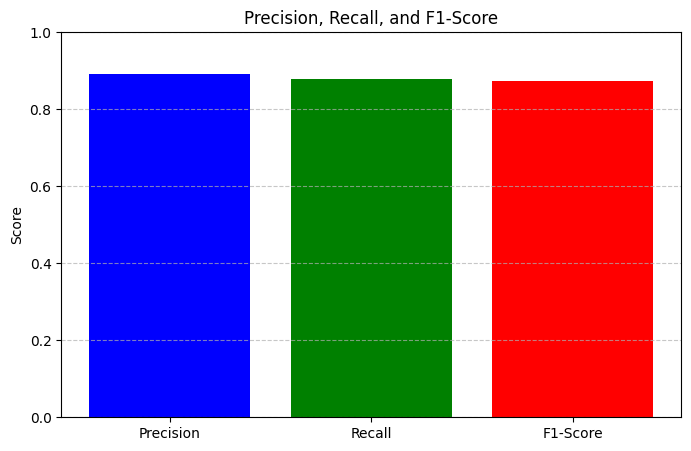

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

X_test_list = []
y_test_list = []

for X_batch, y_batch in test_gen.take(3000):
# take(12000):
    X_test_list.append(X_batch.numpy())
    y_test_list.append(y_batch.numpy())  # .numpy()

    # Gộp tất cả batch lại
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # Nếu y_test đang ở dạng one-hot, chuyển về dạng số
    y_test = np.argmax(y_test, axis=1)
    
model = load_model("cnn_model_2-0_batch512_test015.h5")


y_pred_prob = model.predict(X_test)

y_pred = y_pred_prob.argmax(axis=1)

# Tính Precision, Recall, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


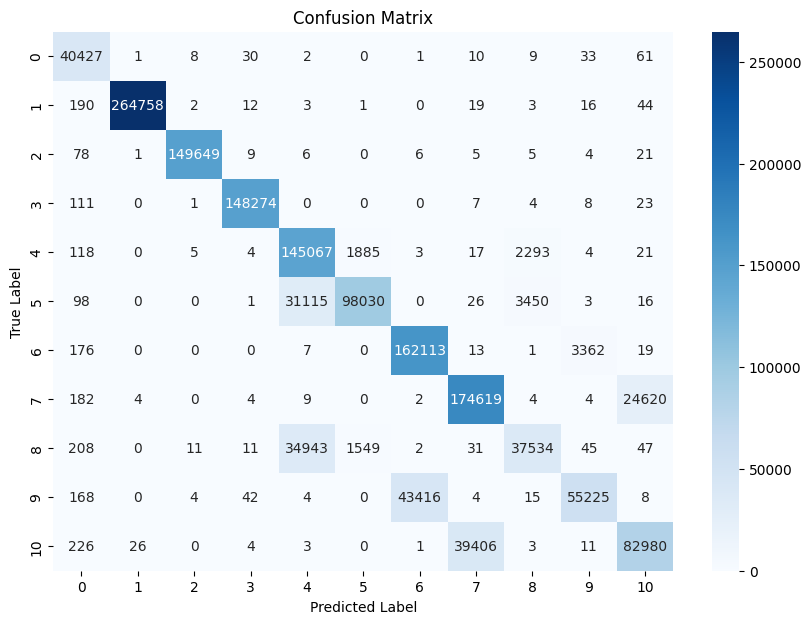

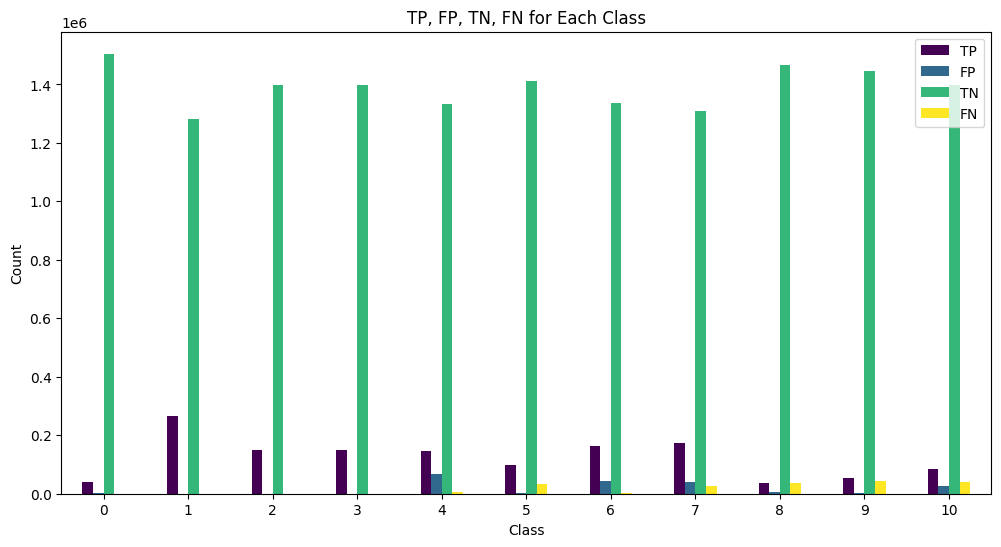

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()

attack_types =['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
                   'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([i, TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 6), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

# Load Model Để Test


In [ ]:
from tensorflow.keras.models import load_model

# Load model từ file .h5
model = load_model("cnn_model_2-0_batch512_test015.h5")

# Test với dữ liệu đầu vào
import numpy as np
output = model.evaluate(test_gen, steps= 190000)
print(f'Loss: {output[0]} Acc: {output[1]}')

190000/190000 ━━━━━━━━━━━━━━━━━━━━ 5428s 29ms/step - accuracy: 0.8963 - loss: 0.2570
Loss: 0.8964436054229736 Acc: 0.8964436054229736


# Lấy weight và biaseses thử add noise và encrypt bằng he

In [10]:
from keras.models import load_model

model = load_model("cnn_model_2-0_batch512_test015.h5")

import numpy as np

weights_list = []
biases_list = []

for layer in model.layers:
    if len(layer.get_weights()) == 2:  # Chỉ lấy các layer có weights & biaseses
        weights, biases = layer.get_weights()
        weights_list.append(weights)
        biases_list.append(biases)
        print(f'{layer.name}: {weights.shape}')

# Kiểm tra định dạng
for i, (w, b) in enumerate(zip(weights_list, biases_list)):
    print(f"Layer {i}:")
    print(f"  Weights shape: {w.shape}, type: {type(w)}")  # Phải là numpy.ndarray
    print(f"  biases shape: {b}, type: {type(b)}")

conv1d_2: (3, 1, 32)
conv1d_3: (3, 32, 64)
dense_2: (320, 128)
dense_3: (128, 10)
Layer 0:
  Weights shape: (3, 1, 32), type: <class 'numpy.ndarray'>
  biases shape: [ 0.00746593  0.00301023  0.00140298  0.00127894 -0.00087526  0.00642537
  0.01093149  0.02646044  0.0380397   0.02935044  0.00510938  0.00932753
  0.06924677  0.03779991  0.          0.01285758 -0.00671828 -0.00600032
 -0.03278909 -0.02948338  0.02428965 -0.00771933  0.01452935 -0.00644274
  0.01935405  0.02527189  0.01754085  0.00123567  0.02319421  0.01327934
  0.00589694 -0.00663931], type: <class 'numpy.ndarray'>
Layer 1:
  Weights shape: (3, 32, 64), type: <class 'numpy.ndarray'>
  biases shape: [-4.0109949e-03  2.1090772e-02 -1.1865907e-02  1.3370344e-02
  3.6280412e-02  2.8803961e-02  2.9495943e-02  3.5041712e-02
  3.2986913e-02  2.0061057e-02  0.0000000e+00  3.5872792e-03
 -3.7027916e-04 -1.6037798e-02  4.6437168e-03  1.6579209e-02
  2.0183949e-02  3.3145886e-02  5.0951920e-02  1.3658903e-02
  2.2172946e-02  3.973

In [ ]:
import copy
import sys
import numpy as np
import random
import threading

import config # config.py

from warnings import simplefilter
from datetime import datetime
from sklearn import metrics

from differential_privacy import laplace

num_clients  = 3  # Số client
active_clients = {'client_agent_' + str(i) for i in range(num_clients)}
print(active_clients)

# số vòng lặp
iteration = 10

#Shape
weights_shape = weights_list[-1].shape
weights_dp_noise = np.zeros(weights_shape)

biases_shape = biases_list[-1].shape
biases_dp_noise = np.zeros(biases_shape)

print(weights_shape)

# generate DP parameters
len_per_iteration = 50
LENS_PER_ITERATION = {client_name: len_per_iteration for client_name in active_clients}
active_clients_lens = [LENS_PER_ITERATION[client_name] for client_name in active_clients]
print(active_clients_lens)

smallest_dataset = min(active_clients_lens)
if config.USING_CUMULATIVE:
    smallest_dataset *= iteration

sensitivity = 2 / ( len(active_clients) * smallest_dataset * config.alpha)
# :3
epsilon = config.EPSILONS['client_agent_0']

random.seed(config.RANDOM_SEEDS['client_agent_0'][iteration])
# adding differentially private noise
for i in range(weights_shape[0]):  # weights_modified is 2-D
    for j in range(weights_shape[1]):
        dp_noise = laplace(mean=config.mean, sensitivity=sensitivity, epsilon=epsilon)
        weights_dp_noise[i][j] = dp_noise

for i in range(biases_shape[0]):
    dp_noise = laplace(mean=config.mean, sensitivity=sensitivity, epsilon=epsilon)
    biases_dp_noise[i] = dp_noise

weights_with_noise = copy.deepcopy(weights)  # make a copy to not mutate weights
biases_with_noise = copy.deepcopy(biases)

weights_with_noise += weights_dp_noise
biases_with_noise += biases_dp_noise
# return weights_with_noise, biases_with_noise

for l in weights_with_noise:
    print("Line1: ", weights_with_noise)

{'client_agent_0': [885440, 403958, 794772, 933488, 441001, 42450, 271493, 536110, 509532, 424604, 962838, 821872, 870163, 318046, 499748, 375441, 611720, 934973, 952225, 229053, 529202, 146039, 295528, 146534, 792518, 99437, 648406, 838234, 262674, 953938, 558433, 739426, 849574, 631140, 945989, 154100, 325213, 103560, 765284, 77324, 942500, 891786, 717209, 346236, 495077, 587007, 105592, 370977, 455262, 331556, 640561, 671532, 957361, 214410, 579363, 500181, 464197, 907343, 546678, 273145, 65304, 844132, 963080, 575352, 960489, 14723, 97802, 754665, 880899, 418196, 744754, 864912, 823182, 700609, 655638, 1198, 641620, 517553, 868287, 909747, 349317, 255759, 765752, 341001, 737822, 912755, 66043, 200348, 961564, 595078, 232473, 250206, 842368, 149416, 842194, 569366, 469730, 95646, 84353, 335601], 'client_agent_1': [917595, 532614, 978147, 513054, 114355, 316089, 578045, 305230, 740883, 130873, 574033, 348914, 854030, 967048, 566528, 213072, 838260, 632485, 573812, 616161, 301630, 466

In [17]:
import tenseal as ts
import numpy as np

# 1. Khởi tạo hệ thống mã hóa TenSEAL với CKKS để hỗ trợ số thực
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2**40
context.generate_galois_keys()

Dx = []
Dy = []

def homophoric_encryption(L2):
    FN = True
    for L in L2:
        row_Dx = []
        row_Dy = []
        for E in L:
            if E == 0:
                FN = False
                break
            
        if FN:
            Eopt = np.random.choice(['add', 'sub', 'mult'])  # Tránh chia 0
        else:
            Eopt = np.random.choice(['add', 'sub', 'mult', 'div'])

        if Eopt != 'div':
            Bl = np.random.randint(1, 9)  # Giá trị cố định cho cả L
            for E in L:
                Eint = E
                if Eopt == 'add':
                    Eflt = Eint + Bl
                elif Eopt == 'sub':
                    Eflt = Eint - Bl
                elif Eopt == 'mult':
                    Eflt = Eint * Bl
                
                Eflt = -Eflt if Eint * Eflt < 0 else Eflt
                encrypted_E = ts.ckks_vector(context, [Eflt])
                row_Dx.append((encrypted_E, Bl, Eopt))
        else:
            for E in L:
                factors = [b for b in range(1, E + 1) if E % b == 0]
                Bl = np.random.choice(factors) if factors else 1
                Eint = E
                Eflt = (Eint / Bl)
                Eflt = -Eflt if Eint * Eflt < 0 else Eflt
                encrypted_E = ts.ckks_vector(context, [Eflt])  # Mã hóa dữ liệu tại đây
                row_Dy.append((encrypted_E, Bl, Eopt))
                
        Dx.append(row_Dx)
        Dy.append(row_Dy)
        
homophoric_encryption(weights_with_noise)
def decrypt_data(context, encrypted_data):
    """Giải mã dữ liệu mã hóa."""
    return encrypted_data.decrypt()

print(Dx)
print("------------\n")
print(Dy)
print("-----------------------\n")
for L in Dx:
    for E in L:
        print(decrypt_data(context, E[0]))
    print("---------------------------|||||\n")

[[(<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A714BF450>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A713A4A10>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A4CE4FF90>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A4CE6ECD0>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A72A1EC90>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A72A14E90>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A72A37710>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A7FD3CA50>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A7FD3E450>, 1, np.str_('add')), (<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A7FD75910>, 1, np.str_('add'))], [(<tenseal.tensors.ckksvector.CKKSVector object at 0x0000025A7FD3F950>, 7, np.str_('mul